# Data Mining Challange: *Reddit Gender Text-Classification* 

### Modules

In [1]:
# Numpy & matplotlib for notebooks 
%pylab inline

# Pandas for data analysis and manipulation 
import pandas as pd 

# Sparse matrix package for numeric data.
from scipy import sparse

# Module for word embedding (word2vector)
import gensim  

# Module for progress monitoring
import tqdm   

# Sklearn 
from sklearn.preprocessing import StandardScaler # to standardize features by removing the mean and scaling to unit variance (z=(x-u)/s)
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron classifier which optimizes the log-loss function using LBFGS or sdg.
from sklearn.svm import SVC # Support Vector Classification
from sklearn.ensemble import RandomForestClassifier # A meta-estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting
from sklearn.decomposition import PCA, TruncatedSVD # Principal component analysis (PCA); dimensionality reduction using truncated SVD.
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB # Naive Bayes classifier for multinomial models
from sklearn.feature_extraction.text import CountVectorizer # Convert a collection of text documents to a matrix of token counts
from sklearn.metrics import roc_auc_score as roc # Compute Area Under the Receiver Operating Characteristic Curve from prediction scores
from sklearn.metrics import roc_curve, auc # Compute ROC; Compute Area Under the Curve (AUC) using the trapezoidal rule
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV # Exhaustive search over specified parameter values for a given estimator
from sklearn.model_selection import cross_val_score # Evaluate a score by cross-validation
from sklearn.model_selection import train_test_split # to split arrays or matrices into random train and test subsets
from sklearn.model_selection import KFold # K-Folds cross-validator providing train/test indices to split data in train/test sets.
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import StratifiedKFold

#XGBoost
from xgboost import XGBRegressor

# Matplotlib
import matplotlib # Data visualization
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches  

# Seaborn
import seaborn as sns # Statistical data visualization (based on matplotlib)

# Joblib 
import joblib # To save models 

Populating the interactive namespace from numpy and matplotlib


### Data Collection 

In [2]:
# Import the training dataset and target

# Import the training dataset
train_data = pd.read_csv("../input/final-dataset/train_data.csv", encoding="utf8")

# Import the target
target = pd.read_csv("../input/final-dataset/train_target.csv")

# Create a dictionary of authors
author_gender = {}
for i in range(len(target)):
    author_gender[target.author[i]] = target.gender[i]

### Data Manipulation 

In [3]:
# Create a list of genders
y = []
# Create a list of authors
a = []

# Populate the lists 
for author, group in train_data.groupby("author"):
    y.append(author_gender[author])
    a.append(author)

# True targets of the last thousand authors
y_valid = np.load("../input/final-dataset/y_valid.npy")

# Predictions of MLP on doc2vec
x1 = np.load("../input/final-dataset/y_scoremlpClf.npy") # y_D2V-mlpClf.npy
# Predictions of XGB on doc2vec
# x1b = np.load("../input/final_dataset/y_D2V-XGB.npy")
# Predictions of XGB on countvectorized texts
x2 = np.load("../input/final-dataset/y_predict_XGB.npy")
# Predictions of MLP on countvectorized subreddits
x3 = np.load("../input/final-dataset/y_score_MLPs.npy")
# x3b = np.load("../input/final_dataset/subs.npy")[:,0]
# x4 = np.load("../input/final_dataset/w2vy.npy")

# Vertically stack
a = np.vstack((x1,x2,x3)) # removed x1b,x3b,x4 

X = a.T # transpose

### Data Visualization 

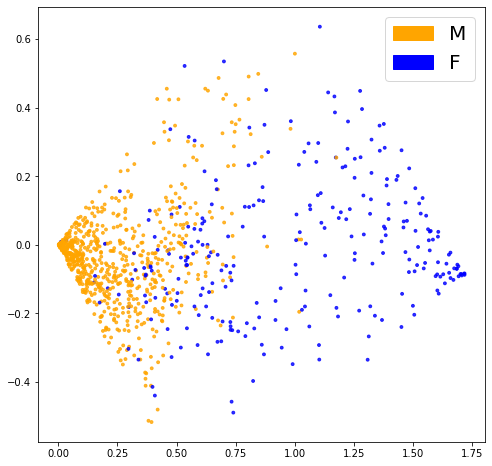

In [4]:
# Plot the test data along the 2 dimensions of largest variance
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='M')
            blue_patch = mpatches.Patch(color='blue', label='F')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 20})

fig = plt.figure(figsize=(8, 8))          
plot_LSA(X, y_valid)
plt.show()

### Models Definition, Training & Validation

#### MLP Classifier

In [5]:
# Split the data for training 
x_train , x_validation, y_train , y_validation = train_test_split(X, y_valid, 
                                                                  train_size=0.8, test_size=0.2, random_state=0)

# Define MLP Classifier:
## Activation function for the hidden layer: "rectified linear unit function"
## Solver for weight optimization: "stochastic gradient-based optimizer"
## Alpha: regularization parameter
## Learning rate schedule for weight updates: "gradually decreases the learning rate at each time step t using an inverse scaling exponent of power_t"
## Verbose: "True" in order to print progress messages to stdout.
## Early stopping: "True" in order to use early stopping to terminate training when validation score is not improving. It automatically sets aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs.

#mlpClf = MLPClassifier(solver = 'adam', activation= 'relu', alpha = 0.01, verbose = True, early_stopping = True, learning_rate = 'invscaling', max_iter = 400)

# Parameters: new parameters 
parameters = {'activation': ['relu'], 'solver': ['lbfgs', 'adam'], 'max_iter': [200,250,300,350,400,450,500], 'alpha': 10.0 ** -np.arange(1, 10)}

# Model exploration
mlpClf = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, scoring= 'roc_auc', cv= StratifiedKFold(n_splits=10, shuffle = True, random_state = 1001))

# Model fit
mlpClf.fit(X,y_valid)

print("mlpCLf.best_score = ", mlpClf.best_score_)

# Save model
joblib.dump(mlpClf, 'mlpClf.pkl')

mlpCLf.best_score =  0.9393219088424567


['mlpClf.pkl']

#### LR Classifier

In [6]:
# Parameters selection
parameters ={'penalty' : ['l1', 'l2'],
             'C' : [1, 0.1,0.01,0.001,0.0001,0.00001,0.000001,10,100,2,3,2.6],
             "class_weight" : ["balanced",],
             'solver' : [ 'liblinear', 'saga']}

logistic = LogisticRegression(class_weight = "balanced") 

# Model exploration
lrClf = GridSearchCV(logistic, param_grid = parameters, cv = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1001), scoring = "roc_auc" ,verbose=True, n_jobs=-1)

# Model fit
lrClf.fit(X,y_valid)

print("lrCLf.best_score = ", lrClf.best_score_)

# Save model
joblib.dump(lrClf, 'lrClf.pkl')

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


lrCLf.best_score =  0.9391721806105368


[Parallel(n_jobs=-1)]: Done 460 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    2.0s finished


['lrClf.pkl']

#### XGB Regressor

In [7]:
# Parameters selection
parameters = {'min_child_weight': [1,8],'gamma': [0.6,0.8],
               'subsample': [0.9], 'colsample_bytree': [0.6],
               'max_depth': [4], 'scale_pos_weight': [1,2.70, 10, 25, 50, 75, 100, 1000] }

    
xgb = XGBRegressor(objective = "reg:logistic", n_estimators=10000, 
                   learning_rate=0.05, tree_method = "gpu_hist", gpu_id = 0)

# Model exploration
xgbClf = GridSearchCV(xgb, param_grid = parameters, cv = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1001), scoring = "roc_auc" ,verbose=True, n_jobs=-1)

# Model fit
xgbClf.fit(X, y_valid, verbose=False)

print("xgbCLf.best_score = ", xgbClf.best_score_)

# Save model
joblib.dump(xgbClf, '../working/xgbClf.pkl')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 32 candidates, totalling 320 fits


/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 73.7min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 120.2min finished


xgbCLf.best_score =  0.9203968061844774


['../working/xgbClf.pkl']

In [8]:
# here we use random grid search beacause the standar done required escessive compuatational time

#parameters = {'min_child_weight': [1,8],'gamma': [0.6,0.8],
#              'subsample': [0.9], 'colsample_bytree': [0.6],
#              'max_depth': [4], 'scale_pos_weight': [1,2.70, 10, 25, 50, 75, 100, 1000] }

#xgb = XGBRegressor(objective = "reg:logistic",n_estimators=10000, learning_rate=0.05, n_jobs=4)

#folds = 5
#param_comb = 18

#skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

#random_search = RandomizedSearchCV(xgb, param_distributions=parameters, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,y_valid), verbose=3, random_state=0)

#print('\n Best score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
#print(random_search.best_score_)
#print('\n Best hyperparameters:')
#print(random_search.best_params_)
#results = pd.DataFrame(random_search.cv_results_)
#results.to_csv('../working/xgb-random-grid-search-results-01.csv', index=False)
# save model
#joblib.dump(xgbClf, '../working/xgbClf.pkl')

### Model Selection 

The **logistic regression** has shown the best performance and therefore it's the one we are going to apply from now on.